# Import Dependencies and Data import

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv("./Dataset/train.csv")

In [3]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
df[df.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

# Preprocessing

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
X = df["comment_text"]
Y = df[df.columns[2:]].values

In [7]:
MAX_FEATURES = 200000 #directly proportional to model efficiency but more max features leads to more vram usage

In [8]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int'
                              )

In [9]:
vectorizer.adapt(X.values)

In [10]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [11]:
vectorizer("Hai, This is venkatasatya")[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([16890,    14,     9,     1,     0], dtype=int64)>

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [14]:
#MCSHBAP rule for building pipelines - Map, Cache, Shuffle, Batch, prefetch from tensor_slices
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,Y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) #helps bottlenecks

In [15]:
batch_X, batch_Y = dataset.as_numpy_iterator().next()

In [16]:
batch_X.shape, batch_Y.shape

((16, 1800), (16, 6))

In [17]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*9)).take(int(len(dataset)*.1))

In [18]:
train_generator = train.as_numpy_iterator()
train_generator.next()

(array([[     2,   2878,   1657, ...,      0,      0,      0],
        [     7,   2076,   2184, ...,      0,      0,      0],
        [   923,    171,   1355, ...,      0,      0,      0],
        ...,
        [   451, 130725,     50, ...,      0,      0,      0],
        [    14,     44,    251, ...,      0,      0,      0],
        [   140,    147,     52, ...,      0,      0,      0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

# Building the Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [20]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1,32))
model.add(Bidirectional(LSTM(32, activation = 'tanh')))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(6, activation = 'sigmoid'))

In [21]:
model.compile(loss = 'BinaryCrossentropy', optimizer = 'Adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [24]:
history = model.fit(train, epochs = 5, validation_data = val)

Epoch 1/5
6981/6981 [==============================] - 6433s 922ms/step - loss: 0.0599 - val_loss: 0.0456
Epoch 2/5
6981/6981 [==============================] - 5580s 799ms/step - loss: 0.0455 - val_loss: 0.0410
Epoch 3/5
6981/6981 [==============================] - 5584s 800ms/step - loss: 0.0408 - val_loss: 0.0373
Epoch 4/5
6981/6981 [==============================] - 5593s 801ms/step - loss: 0.0363 - val_loss: 0.0304
Epoch 5/5
6981/6981 [==============================] - 5557s 796ms/step - loss: 0.0323 - val_loss: 0.0277


<Figure size 800x500 with 0 Axes>

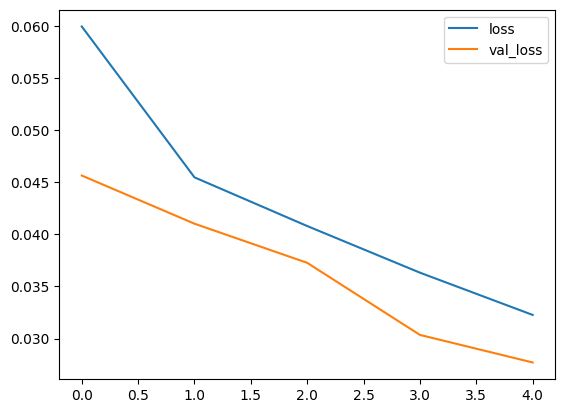

In [25]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Make predictions

In [45]:
def toxic_check(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {} \n'.format(col, results[0][idx]>0.5)
    
    return text

In [46]:
toxic_check('i hate you and i\'ll kill you')

1/1 [==============================] - 2s 2s/step


'toxic: True \nsevere_toxic: False \nobscene: False \nthreat: False \ninsult: True \nidentity_hate: False \n'

1/1 [==============================] - 0s 193ms/step


# Evaluate Model

In [30]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [31]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [32]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [33]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.0, Recall:0.0, Accuracy:0.0


# Test & Gradio

In [39]:
import warnings

warnings.filterwarnings('ignore')

In [40]:
import tensorflow as tf
import gradio as gr

In [41]:
model.save('toxicity.h5')

In [42]:
model = tf.keras.models.load_model('toxicity.h5')

In [43]:
interface = gr.Interface(fn = toxic_check, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [44]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://63d4e3914c55859eb5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
